# Check dataflow

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os 
import sys

In [3]:
root_path = os.path.abspath("..")
if root_path not in sys.path:
    sys.path.append(root_path)

In [4]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [5]:
from common.dataflow import get_train_df, get_test_df, get_image, get_target, get_inc_angle
from common.dataflow_visu_utils import display_image
from common.dataflow import IcebergDataset

In [6]:
from common.dataflow_visu_utils import display_dataset, display_data_augmentations, display_batches

In [7]:
trainval_ds = IcebergDataset('Train')
test_ds = IcebergDataset('Test')

x:  <class 'numpy.ndarray'> (75, 75, 2) -38.2114 -0.213149 -41.1359 -11.2522
y:  <class 'numpy.int64'> 1
x:  <class 'numpy.ndarray'> (75, 75, 2) -23.1253 12.5704 -34.7658 0.044052
y:  <class 'numpy.int64'> 1
x:  <class 'numpy.ndarray'> (75, 75, 2) -33.3912 -9.91848 -34.1488 -15.6059
y:  <class 'numpy.int64'> 1
x:  <class 'numpy.ndarray'> (75, 75, 2) -32.2041 4.79563 -39.5641 -5.55452
y:  <class 'numpy.int64'> 1
x:  <class 'numpy.ndarray'> (75, 75, 2) -35.0105 -6.95604 -40.2761 -9.43401
y:  <class 'numpy.int64'> 1
x:  <class 'numpy.ndarray'> (75, 75, 2) -29.7157 3.86404 -37.674 -9.12756
y:  <class 'numpy.int64'> 1
x:  <class 'numpy.ndarray'> (75, 75, 2) -35.9261 -10.3501 -36.8422 -17.4397
y:  <class 'numpy.int64'> 1
x:  <class 'numpy.ndarray'> (75, 75, 2) -37.3003 -13.9976 -37.2979 -22.1081
y:  <class 'numpy.int64'> 1
x:  <class 'numpy.ndarray'> (75, 75, 2) -25.7325 28.5789 -34.252 -1.07451
y:  <class 'numpy.int64'> 1
x:  <class 'numpy.ndarray'> (75, 75, 2) -36.0653 -5.6063 -38.2482 -15

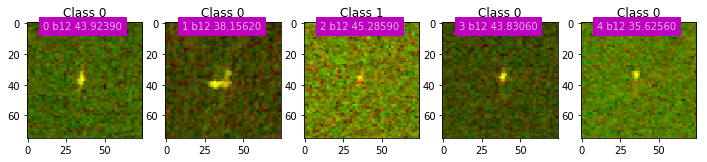

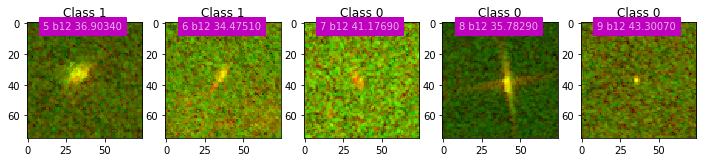

In [9]:
display_dataset(trainval_ds, max_datapoints=10, show_info=True)

In [10]:
%%timeit -r2 -n5
for (x, a), y in trainval_ds:
    x.sum()

1.26 s ± 10.5 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)


x:  <class 'numpy.ndarray'> (75, 75, 2) -26.7006 7.28603 -34.3635 -16.2145
y:  <class 'str'> 8
x:  <class 'numpy.ndarray'> (75, 75, 2) -34.1768 -10.5493 -38.1012 -10.7599
y:  <class 'str'> 8
x:  <class 'numpy.ndarray'> (75, 75, 2) -34.0697 18.9681 -37.5925 19.0644
y:  <class 'str'> 8
x:  <class 'numpy.ndarray'> (75, 75, 2) -27.2938 1.69518 -35.0941 -6.58381
y:  <class 'str'> 8
x:  <class 'numpy.ndarray'> (75, 75, 2) -33.387 -8.12234 -35.8867 -8.77815
y:  <class 'str'> 8
x:  <class 'numpy.ndarray'> (75, 75, 2) -32.5693 6.89931 -30.9879 5.77728
y:  <class 'str'> 8
x:  <class 'numpy.ndarray'> (75, 75, 2) -37.1353 -5.83 -39.6348 -14.7732
y:  <class 'str'> 8
x:  <class 'numpy.ndarray'> (75, 75, 2) -29.9917 3.36454 -36.9303 -13.8703
y:  <class 'str'> 8
x:  <class 'numpy.ndarray'> (75, 75, 2) -33.0868 15.5735 -37.3044 0.552376
y:  <class 'str'> 8
x:  <class 'numpy.ndarray'> (75, 75, 2) -26.622 11.1458 -33.5917 5.93408
y:  <class 'str'> 8


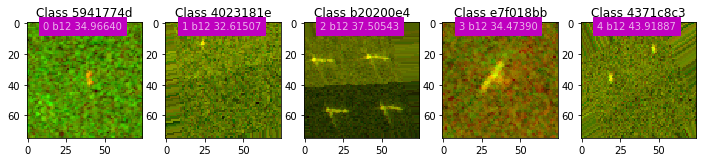

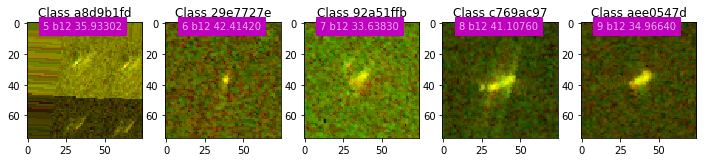

In [14]:
display_dataset(test_ds, max_datapoints=10, show_info=True)

Compute min, max, mean on the train dataset

In [16]:
def compute_min_max_mean(ds):
    min_vals = [] 
    max_vals = []
    mean_vals = []
    for (x, a), y in ds:
        min_vals.append((x[:, :, 0].min(), x[:, :, 1].min()))
        max_vals.append((x[:, :, 0].max(), x[:, :, 1].max()))
        mean_vals.append((x[:, :, 0].mean(), x[:, :, 1].mean()))

    min_vals = np.array(min_vals)
    max_vals = np.array(max_vals)
    mean_vals = np.array(mean_vals)
    return min_vals, max_vals, mean_vals

train_min_vals, train_max_vals, train_mean_vals = compute_min_max_mean(trainval_ds)
test_min_vals, test_max_vals, test_mean_vals = compute_min_max_mean(test_ds)

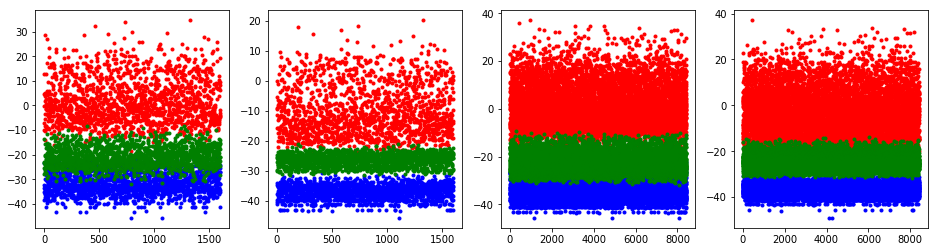

In [18]:
plt.figure(figsize=(16, 4))
plt.subplot(141)
plt.plot(train_min_vals[:, 0], 'b.', label='mins')
plt.plot(train_max_vals[:, 0], 'r.', label='maxs')
plt.plot(train_mean_vals[:, 0], 'g.', label='mean')
plt.subplot(142)
plt.plot(train_min_vals[:, 1], 'b.', label='mins')
plt.plot(train_max_vals[:, 1], 'r.', label='maxs')
plt.plot(train_mean_vals[:, 1], 'g.', label='mean')

plt.subplot(143)
plt.plot(test_min_vals[:, 0], 'b.', label='mins')
plt.plot(test_max_vals[:, 0], 'r.', label='maxs')
plt.plot(test_mean_vals[:, 0], 'g.', label='mean')
plt.subplot(144)
plt.plot(test_min_vals[:, 1], 'b.', label='mins')
plt.plot(test_max_vals[:, 1], 'r.', label='maxs')
plt.plot(test_mean_vals[:, 1], 'g.', label='mean')

In [11]:
np.percentile(mean_vals, q=50.0, axis=0), np.percentile(max_vals, q=97.0, axis=0) - np.percentile(min_vals, q=3.0, axis=0)

(array([-21.04982662, -26.15313911]), array([ 59.87096096,  48.35116971]))

In [10]:
import torch
from common.torch_common_utils.dataflow import TransformedDataset, OnGPUDataLoader
from common.dataflow import get_data_transforms

In [12]:
CONFIG = {
  "train_aug": {
    "Compose": {
      "transforms": [
        {"ToFiveBands": {}},
        {"RandomApply": {"proba": 0.7,
          "transforms": [
            {"RandomAffine": {
              "translate": [0.15, 0.15],
              "rotation": [-45, 45],
              "interpolation": 0}},
            {"RandomFlip": {"mode": "h", "proba": 0.75}},
            {"RandomFlip": {"mode": "v", "proba": 0.75}}
          ]}
        },
        {"_ToTensor": {}},
        {"Normalize": {"mean": [0.0, 0.0, 0.0, 0.0, 0.5*50**2], "std": [50, 50, 50, 50, 50**2]}}
      ]}
  },

  "test_aug": {
    "Compose": {
      "transforms": [
        {"ToFiveBands": {}},
        {"RandomFlip": {"mode": "h", "proba": 0.5}},
        {"RandomFlip": {"mode": "v", "proba": 0.5}},
        {"_ToTensor": {}},
        {"Normalize": {"mean": [0.0, 0.0, 0.0, 0.0, 0.5*50**2], "std": [50, 50, 50, 50, 50**2]}}
      ]}
  }  
}


train_aug = get_data_transforms(CONFIG['train_aug'])
test_aug = get_data_transforms(CONFIG['test_aug'])

In [13]:
from functools import partial

def x_transform(x, aug_fn):
    x, a = x
    x = aug_fn(x)
    return x, a

def y_transform(y):
    return torch.FloatTensor([int(y)])

In [14]:
train_aug_ds = TransformedDataset(trainval_ds, 
                                  x_transforms=partial(x_transform, aug_fn=train_aug), 
                                  y_transforms=y_transform)

val_aug_ds = TransformedDataset(trainval_ds, 
                                x_transforms=partial(x_transform, aug_fn=test_aug), 
                                y_transforms=y_transform)

test_aug_ds = TransformedDataset(test_ds, 
                                 x_transforms=partial(x_transform, aug_fn=test_aug))

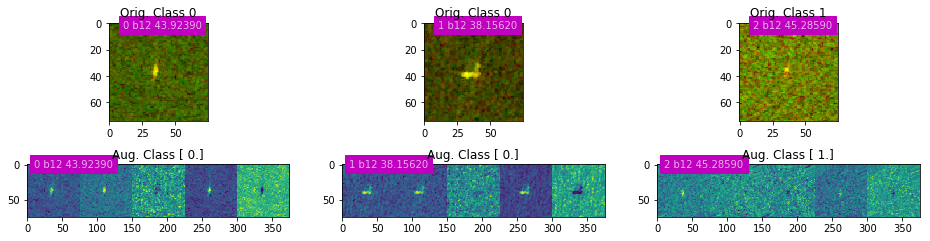

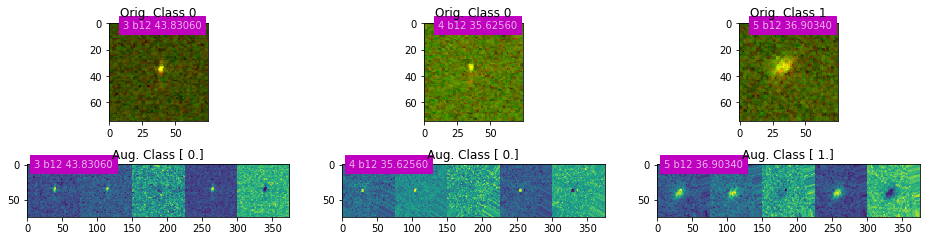

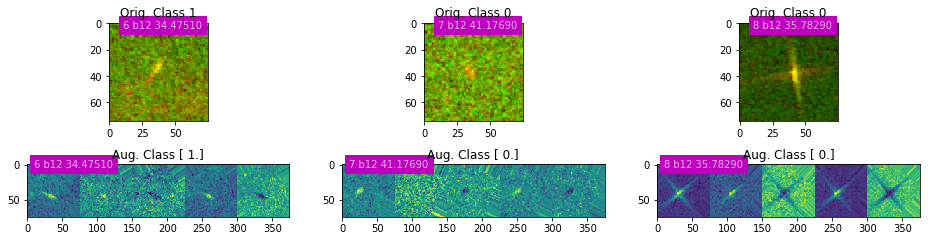

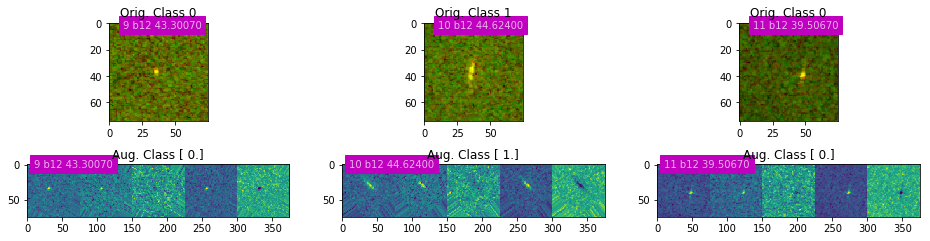

In [15]:
display_data_augmentations(trainval_ds, train_aug_ds, max_datapoints=12, n_cols=3, figsize=(16, 4))

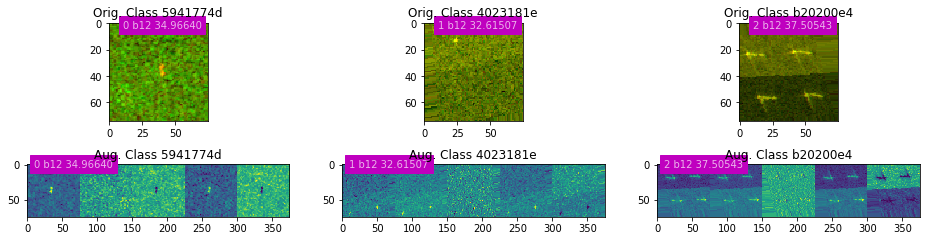

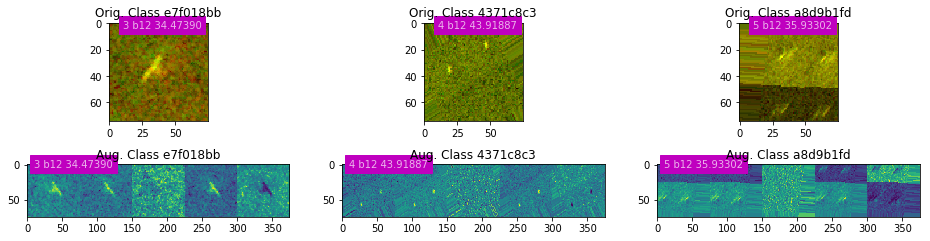

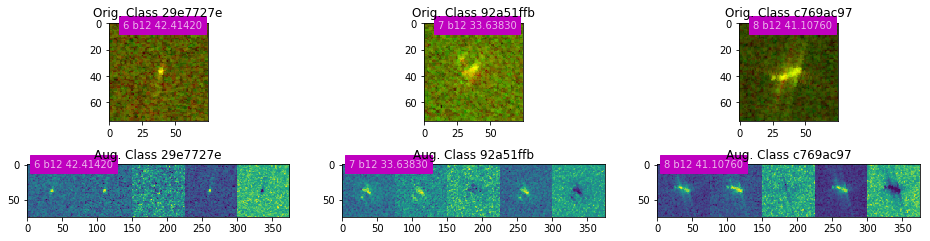

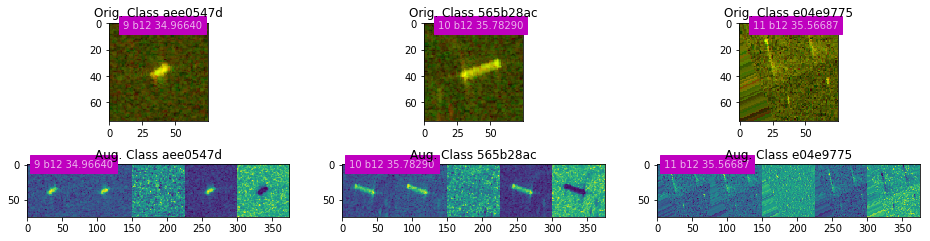

In [16]:
display_data_augmentations(test_ds, test_aug_ds, max_datapoints=12, n_cols=3, figsize=(16, 4))

In [18]:
(x, a), y = train_aug_ds[0]

In [19]:
for i in range(x.size(0)):
    print(torch.min(x[i, :, :]), torch.max(x[i, :, :]))

-0.7642275094985962 -0.004262980073690414
-0.8227183818817139 -0.22504307329654694
-0.2948240041732788 0.18429233133792877
-1.4229241609573364 -0.2581275999546051
-0.498899906873703 0.0060945311561226845


x:  <class 'torch.FloatTensor'> torch.Size([5, 75, 75]) -1.3296297788619995 0.13431678712368011 -1.3025407791137695 0.12041191011667252
y:  <class 'torch.FloatTensor'> torch.Size([1])
x:  <class 'torch.FloatTensor'> torch.Size([5, 75, 75]) -0.9383706450462341 -0.10790889710187912 -0.8747068047523499 -0.06025764346122742
y:  <class 'torch.FloatTensor'> torch.Size([1])
x:  <class 'torch.FloatTensor'> torch.Size([5, 75, 75]) -1.1598846912384033 0.13361209630966187 -1.1169745922088623 0.07401847839355469
y:  <class 'torch.FloatTensor'> torch.Size([1])
x:  <class 'torch.FloatTensor'> torch.Size([5, 75, 75]) -1.1806493997573853 -0.008475685492157936 -1.182562232017517 0.059904977679252625
y:  <class 'torch.FloatTensor'> torch.Size([1])
x:  <class 'torch.FloatTensor'> torch.Size([5, 75, 75]) -1.1306153535842896 0.15360169112682343 -1.204419732093811 0.15360169112682343
y:  <class 'torch.FloatTensor'> torch.Size([1])


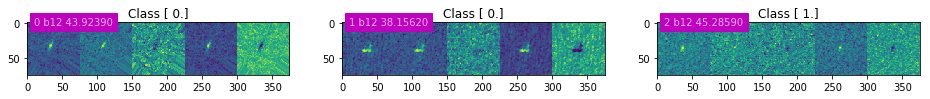

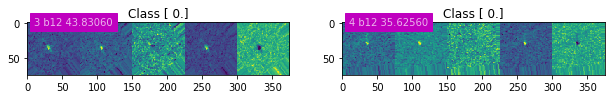

In [20]:
display_dataset(train_aug_ds, max_datapoints=5, n_cols=3, figsize=(16, 4), show_info=True)

x:  <class 'torch.FloatTensor'> torch.Size([5, 75, 75]) -0.957893967628479 -0.04213729873299599 -0.9889182448387146 -0.014484863728284836
y:  <class 'str'> 1
x:  <class 'torch.FloatTensor'> torch.Size([5, 75, 75]) -1.260067105293274 0.1204112246632576 -1.2025043964385986 0.13431605696678162
y:  <class 'str'> 1
x:  <class 'torch.FloatTensor'> torch.Size([5, 75, 75]) -1.1524338722229004 0.08814844489097595 -1.1524338722229004 0.08814844489097595
y:  <class 'str'> 1
x:  <class 'torch.FloatTensor'> torch.Size([5, 75, 75]) -0.9949542284011841 -0.017924919724464417 -0.9902732372283936 -0.0641644299030304
y:  <class 'str'> 1
x:  <class 'torch.FloatTensor'> torch.Size([5, 75, 75]) -1.1669566631317139 0.09590339660644531 -1.1763415336608887 0.09590339660644531
y:  <class 'str'> 1


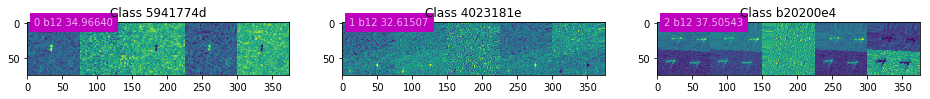

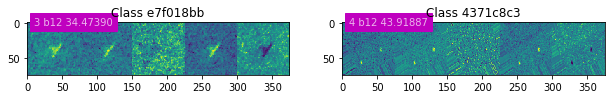

In [22]:
display_dataset(test_aug_ds, max_datapoints=5, n_cols=3, figsize=(16, 4), show_info=True)

In [23]:
CONFIG = {
    'batch_size': 10,
    'num_workers': 12,
    'n_splits': 10,
    'val_size': 0.10,

    'seed': 12345
}

In [24]:
y_array = []
x_array = []
for i, ((x, a), y) in enumerate(trainval_ds):
    y_array.append(y)
    x_array.append(i)    

In [25]:
from sklearn.model_selection import StratifiedShuffleSplit
# Stratified split:        
sssplit = StratifiedShuffleSplit(n_splits=CONFIG['n_splits'], 
                                 test_size=CONFIG['val_size'], 
                                 random_state=CONFIG['seed'])
train_indices, val_indices = next(sssplit.split(x_array, y_array))

In [26]:
from torch.utils.data.sampler import SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

In [27]:
train_batches = OnGPUDataLoader(train_aug_ds,
                                batch_size=CONFIG['batch_size'],
                                sampler=train_sampler,
                                num_workers=CONFIG['num_workers'],
                                drop_last=True,
                                pin_memory=True)

val_batches = OnGPUDataLoader(val_aug_ds,
                              batch_size=CONFIG['batch_size'],
                              sampler=val_sampler,
                              num_workers=CONFIG['num_workers'],
                              drop_last=True,
                              pin_memory=True)

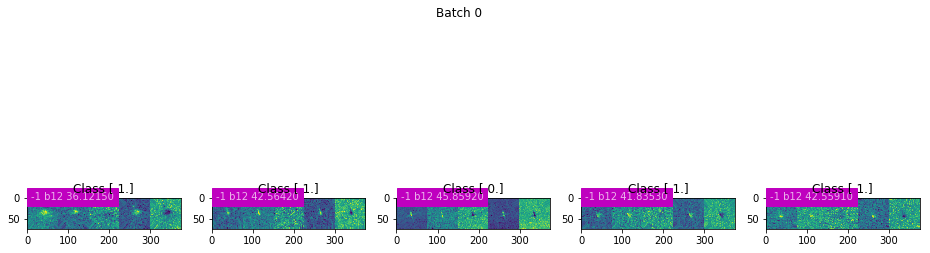

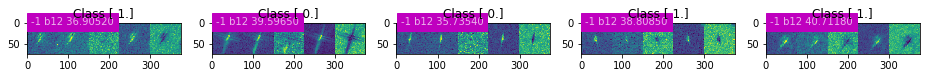

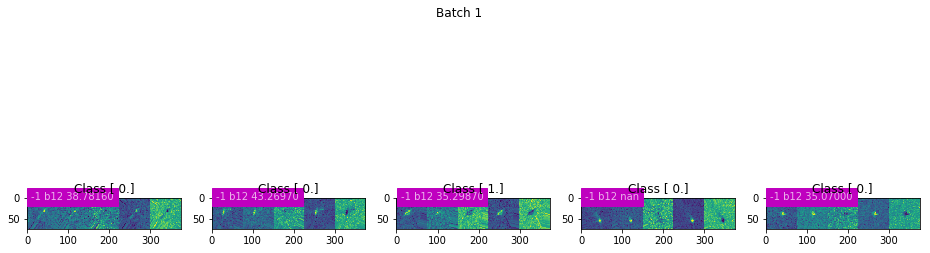

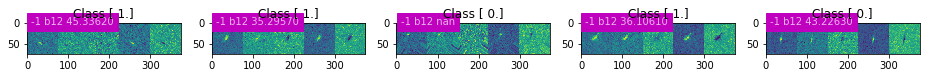

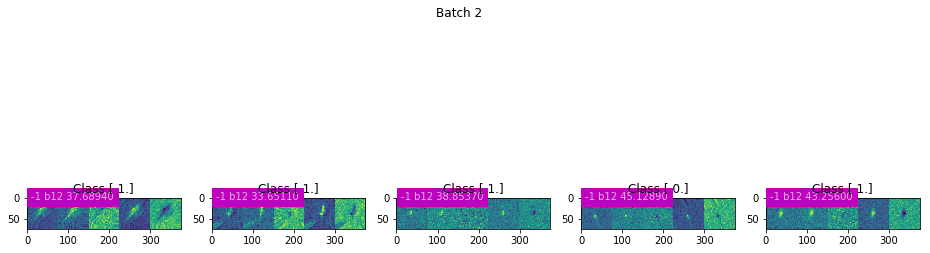

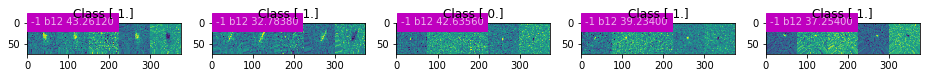

In [28]:
display_batches(train_batches)

In [1]:
import torch

In [2]:
x = 50*torch.randn((3, 75, 75)) + 50.0

In [5]:
torch.min(x), torch.max(x)

(-146.2022705078125, 263.0203857421875)

In [11]:
for i in range(x.size(0)):
    minv = torch.min(x[i, :, :])
    maxv = torch.max(x[i, :, :])
    x[i, :, :].add_(-minv)
    x[i, :, :].mul_(1.0/(maxv - minv))

In [12]:
torch.min(x), torch.max(x)

(0.0, 1.0)